In [ ]:
import pandas as pd
import numpy as np
from copy import deepcopy
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils import resample
from xgboost import XGBClassifier
from hyperopt import fmin, hp, tpe
import seaborn as sns
import matplotlib.pyplot as plt

data loading 

In [ ]:
df = pd.read_csv("new_Base_CDM.csv", delimiter=';', header=1)
df_balanced = pd.read_csv("new_Base_CDM_balanced_V2.csv", delimiter = ';', header = 1)

### première vision sur les données


In [ ]:
print(df.shape)
print(df.info())

(22243, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22243 entries, 0 to 22242
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Display           22243 non-null  object 
 1   cor_sales_in_vol  22243 non-null  float64
 2   cor_sales_in_val  22243 non-null  float64
 3   turnover          22243 non-null  int64  
 4   value             22243 non-null  int64  
 5   ENSEIGNE          22243 non-null  object 
 6   VenteConv         22243 non-null  float64
 7   Feature           22242 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.4+ MB
None


In [ ]:
print(df_balanced.shape)
print(df_balanced.info())

(25782, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25782 entries, 0 to 25781
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Display           25782 non-null  object 
 1   cor_sales_in_vol  25782 non-null  float64
 2   cor_sales_in_val  25782 non-null  float64
 3   CA_mag            25782 non-null  int64  
 4   value             25782 non-null  int64  
 5   ENSEIGNE          25782 non-null  object 
 6   VenteConv         25782 non-null  float64
 7   Feature           25782 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 1.6+ MB
None


In [ ]:
df_balanced.Display.unique() 

array(['No_Displ', 'Displ'], dtype=object)

In [ ]:
df_balanced.Display.value_counts() 

No_Displ    13000
Displ       12782
Name: Display, dtype: int64

In [ ]:
df_balanced.ENSEIGNE.unique() 

array(['CORA', 'LECLERC', 'AUCHAN', 'CARREFOUR', 'CASINO', 'SUPER U',
       'GEANT', 'CARREFOUR MARKET', 'FRANPRIX', 'INTERMARCHE',
       'ECOMARCHE', 'MONOPRIX', 'SIMPLY MARKET', 'OTHERS', 'MATCH',
       'PRISUNIC', 'HYPER U', 'SHOPI', 'MARCHE U'], dtype=object)

In [ ]:
numerics_ind = [i for i in range(len(list(df_balanced.dtypes))) if str(list(df_balanced.dtypes)[i]) in ['float64', 'int64']]
numerics_b = []
for e in numerics_ind :
    numerics_b.append(df_balanced.columns[e])

numerics_ = [i for i in range(len(list(df.dtypes))) if str(list(df.dtypes)[i]) in ['float64', 'int64']]
numerics = []
for e in numerics_ind :
    numerics.append(df.columns[e])

In [ ]:
newLabel = LabelEncoder() 
oneHot = OneHotEncoder() 
df.Display = newLabel.fit_transform(df.Display) 
df.Feature = newLabel.fit_transform(df.Feature)
tmpe = oneHot.fit(df.ENSEIGNE.to_numpy().reshape(-1, 1))
tmp = tmpe.transform(df.ENSEIGNE.to_numpy().reshape(-1, 1))
tmp2 = pd.DataFrame(tmp.toarray(), columns = sorted(list(df.ENSEIGNE.unique())))

newLabel2 = LabelEncoder() 
oneHot2 = OneHotEncoder() 
df_balanced.Display = newLabel2.fit_transform(df_balanced.Display) 
df_balanced.Feature = newLabel2.fit_transform(df_balanced.Feature)
tmpe_b = oneHot.fit(df_balanced.ENSEIGNE.to_numpy().reshape(-1, 1))
tmp_b = tmpe_b.transform(df_balanced.ENSEIGNE.to_numpy().reshape(-1, 1))
tmp2_b = pd.DataFrame(tmp_b.toarray(), columns = sorted(list(df_balanced.ENSEIGNE.unique())))

In [ ]:
df = pd.concat([df, tmp2], axis = 1).drop(["ENSEIGNE"], axis = 1) 
df_balanced = pd.concat([df_balanced, tmp2_b], axis = 1).drop(["ENSEIGNE"], axis = 1) 

In [ ]:
df_balanced.head()

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,VenteConv,Feature,AUCHAN,CARREFOUR,CARREFOUR MARKET,CASINO,CORA,ECOMARCHE,FRANPRIX,GEANT,HYPER U,INTERMARCHE,LECLERC,MARCHE U,MATCH,MONOPRIX,OTHERS,PRISUNIC,SHOPI,SIMPLY MARKET,SUPER U
0,1,2.0,20.20,47400,36,72.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.0,11.90,62000,24,48.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,8.0,29.52,60661,60,480.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2.0,16.20,59677,19,38.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5.0,62.10,142602,50,250.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_balanced[numerics_b].describe()

,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,VenteConv
count,25782.000000,25782.000000,25782.000000,25782.000000,25782.000000
mean,13.767151,130.888312,64641.184431,37.646614,587.855260
std,38.203406,372.649805,54924.645702,23.498949,1821.338396
min,1.000000,1.110000,1693.000000,1.000000,1.000000
25%,2.000000,13.360000,21394.000000,25.000000,50.000000
50%,4.000000,31.050000,51522.000000,32.000000,120.000000
75%,11.000000,87.450000,91000.000000,40.000000,380.000000
max,1475.000000,13589.220000,284844.000000,198.000000,48816.000000


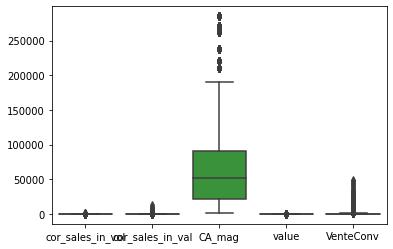

In [ ]:
sns.boxplot(data = df_balanced[numerics_b])

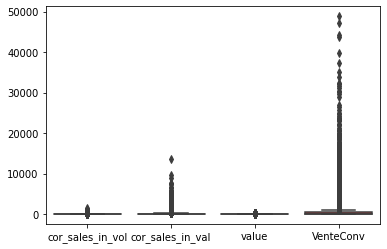

In [ ]:
import copy

num2 = copy.copy(numerics_b)
num2.remove("CA_mag")
sns.boxplot(data = df_balanced[num2])

In [ ]:
df_corr = df_balanced[numerics_b].corr() 
df_corr.style.background_gradient()

,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,VenteConv
cor_sales_in_vol,1.000000,0.858353,0.266049,0.077496,0.882588
cor_sales_in_val,0.858353,1.000000,0.297886,0.230587,0.928348
CA_mag,0.266049,0.297886,1.000000,0.127276,0.275925
value,0.077496,0.230587,0.127276,1.000000,0.288883
VenteConv,0.882588,0.928348,0.275925,0.288883,1.000000


### traitement préliminaire des données balancées

In [ ]:
df_balanced["rapport_vol_val"] = df_balanced["cor_sales_in_val"]/df_balanced["cor_sales_in_vol"]
#df_balanced["diff_vol_val"] = df_balanced["cor_sales_in_val"] - df_balanced["cor_sales_in_vol"]

In [ ]:
numerics_b.append("rapport_vol_val")
for x in ["VenteConv","cor_sales_in_vol","cor_sales_in_val"]:
  numerics_b.remove(x)

In [ ]:
df_crr = df_balanced[numerics_b].corr()
df_crr.style.background_gradient()

,CA_mag,value,rapport_vol_val
CA_mag,1.000000,0.127276,0.121424
value,0.127276,1.000000,0.756515
rapport_vol_val,0.121424,0.756515,1.000000


In [ ]:
df_balanced.drop(["VenteConv","cor_sales_in_vol","cor_sales_in_val"], axis=1, inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=0.2) 
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df_balanced.iloc[:,1:], df_balanced.iloc[:,0], test_size=0.2)

In [ ]:
X_train_b[numerics_b].describe()

,CA_mag,value,rapport_vol_val
count,20625.000000,20625.000000,20625.000000
mean,64577.416485,37.561891,9.246118
std,54912.549012,23.532884,4.495618
min,1693.000000,1.000000,0.909091
25%,21344.000000,25.000000,6.611111
50%,51522.000000,32.000000,8.260000
75%,91000.000000,40.000000,11.210000
max,284844.000000,198.000000,43.390000


In [ ]:
X_train.reset_index(inplace = True) 
X_test.reset_index(inplace = True) 
X_train_b.reset_index(inplace = True) 
X_test_b.reset_index(inplace = True)

In [ ]:
std = StandardScaler().fit(X_train_b[numerics_b]) 
X_train_b[numerics_b] = pd.DataFrame(std.transform(X_train_b[numerics_b]), columns = numerics_b)
X_test_b[numerics_b] = pd.DataFrame(std.transform(X_test_b[numerics_b]), columns = numerics_b)

std2 = StandardScaler().fit(X_train[numerics]) 
X_train[numerics] = pd.DataFrame(std2.transform(X_train[numerics]), columns = numerics)
X_test[numerics] = pd.DataFrame(std2.transform(X_test[numerics]), columns = numerics)

In [ ]:
X_train_b.head()

,index,CA_mag,value,Feature,AUCHAN,CARREFOUR,CARREFOUR MARKET,CASINO,CORA,ECOMARCHE,FRANPRIX,GEANT,HYPER U,INTERMARCHE,LECLERC,MARCHE U,MATCH,MONOPRIX,OTHERS,PRISUNIC,SHOPI,SIMPLY MARKET,SUPER U,rapport_vol_val
0,22190,1.287270,0.103607,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.160035
1,14245,-0.362301,2.483313,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.669195
2,25256,-0.427971,0.103607,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.410658
3,4001,-0.066479,-0.236351,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.303885
4,89,0.090375,0.103607,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.199336


In [ ]:
X_train.drop(["index"], axis = 1, inplace = True) 
X_test.drop(["index"], axis = 1, inplace = True)

### modélisation linéaire

In [ ]:
lrb = LogisticRegressionCV(solver="lbfgs", n_jobs=-1, random_state=42, class_weight="balanced", cv = 10) 
lrb.fit(X_train_b, y_train_b) 

LogisticRegressionCV(class_weight='balanced', cv=10, n_jobs=-1, random_state=42)

Aprés avoir entrainé le modele, on l'alimente avec les données de test et on a obtenue des métriques, a savoir Accuracy, f1_score

In [ ]:
lrb_regul = LogisticRegressionCV(Cs=[0.01,0.1,1,10], solver="lbfgs", n_jobs=-1, random_state=42, class_weight="balanced", cv = 10) 
lrb_regul.fit(X_train_b, y_train_b) 

LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10], class_weight='balanced', cv=10,
                     n_jobs=-1, random_state=42)

In [ ]:
y_pred_regul = lrb_regul.predict(X_test_b)
print(classification_report(y_test_b, y_pred_regul))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2568
           1       0.99      0.99      0.99      2589

    accuracy                           0.99      5157
   macro avg       0.99      0.99      0.99      5157
weighted avg       0.99      0.99      0.99      5157



Wow!!

In [ ]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
lda.fit(X_train_b, y_train_b) 

LinearDiscriminantAnalysis(solver='lsqr')

Aprés avoir entrainé le modele, on l'alimente avec les données de test et on a obtenue des métriques, a savoir Accuracy, f1_score

In [ ]:
y_pret = lda.predict(X_train_b)
print(classification_report(y_train_b, y_pret))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     10214
           1       0.97      0.99      0.98     10411

    accuracy                           0.98     20625
   macro avg       0.98      0.98      0.98     20625
weighted avg       0.98      0.98      0.98     20625



### modélisation non linéaire

In [ ]:
 forest = RandomForestClassifier(n_estimators=250, min_samples_split=4, bootstrap=True, oob_score=True, n_jobs=-1, verbose = 20, class_weight="balanced_subsample")
 forest.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 250
building tree 2 of 250


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s


building tree 3 of 250
building tree 4 of 250


[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s


building tree 5 of 250
building tree 6 of 250


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.1s


building tree 7 of 250
building tree 8 of 250


[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s


building tree 9 of 250
building tree 10 of 250


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s


building tree 11 of 250
building tree 12 of 250


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.2s


building tree 13 of 250
building tree 14 of 250


[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.5s


building tree 15 of 250
building tree 16 of 250
building tree 17 of 250
building tree 18 of 250


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.3s


building tree 19 of 250
building tree 20 of 250


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    3.6s


building tree 21 of 250
building tree 22 of 250


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    4.0s


building tree 23 of 250
building tree 24 of 250


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.3s


building tree 25 of 250
building tree 26 of 250


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s


building tree 27 of 250
building tree 28 of 250


[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.1s


building tree 29 of 250
building tree 30 of 250


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    5.4s


building tree 31 of 250
building tree 32 of 250


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    5.7s


building tree 33 of 250
building tree 34 of 250


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s


building tree 35 of 250
building tree 36 of 250


[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    6.4s


building tree 37 of 250
building tree 38 of 250


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    6.8s


building tree 39 of 250
building tree 40 of 250


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.2s


building tree 41 of 250
building tree 42 of 250


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s


building tree 43 of 250
building tree 44 of 250


[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    7.9s


building tree 45 of 250
building tree 46 of 250


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.2s


building tree 47 of 250
building tree 48 of 250


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    8.5s


building tree 49 of 250
building tree 50 of 250


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.9s


building tree 51 of 250
building tree 52 of 250


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    9.3s


building tree 53 of 250
building tree 54 of 250


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:    9.6s


building tree 55 of 250
building tree 56 of 250


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.0s


building tree 57 of 250
building tree 58 of 250


[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   10.3s


building tree 59 of 250
building tree 60 of 250


[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:   10.7s


building tree 61 of 250
building tree 62 of 250


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   11.0s


building tree 63 of 250
building tree 64 of 250


[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.4s


building tree 65 of 250
building tree 66 of 250


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   11.7s


building tree 67 of 250
building tree 68 of 250
building tree 69 of 250
building tree 70 of 250


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   12.4s


building tree 71 of 250
building tree 72 of 250


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:   12.8s


building tree 73 of 250
building tree 74 of 250


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   13.2s


building tree 75 of 250
building tree 76 of 250


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:   13.5s


building tree 77 of 250
building tree 78 of 250


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:   13.8s


building tree 79 of 250
building tree 80 of 250


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   14.2s


building tree 81 of 250
building tree 82 of 250


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.6s


building tree 83 of 250
building tree 84 of 250


[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   14.9s


building tree 85 of 250
building tree 86 of 250


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:   15.3s


building tree 87 of 250
building tree 88 of 250


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.7s


building tree 89 of 250
building tree 90 of 250


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   16.0s


building tree 91 of 250
building tree 92 of 250


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:   16.4s


building tree 93 of 250
building tree 94 of 250


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   16.7s


building tree 95 of 250
building tree 96 of 250


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   17.0s


building tree 97 of 250
building tree 98 of 250


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   17.4s


building tree 99 of 250
building tree 100 of 250


[Parallel(n_jobs=-1)]: Done  99 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:   17.8s


building tree 101 of 250
building tree 102 of 250


[Parallel(n_jobs=-1)]: Done 101 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:   18.1s


building tree 103 of 250
building tree 104 of 250


[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   18.5s


building tree 105 of 250
building tree 106 of 250


[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:   18.8s


building tree 107 of 250
building tree 108 of 250


[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:   19.2s


building tree 109 of 250
building tree 110 of 250


[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 110 tasks      | elapsed:   19.6s


building tree 111 of 250
building tree 112 of 250


[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   19.9s


building tree 113 of 250
building tree 114 of 250


[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   20.2s


building tree 115 of 250
building tree 116 of 250


[Parallel(n_jobs=-1)]: Done 115 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   20.5s


building tree 117 of 250
building tree 118 of 250


[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:   20.9s


building tree 119 of 250
building tree 120 of 250


[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   21.2s


building tree 121 of 250
building tree 122 of 250


[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   21.6s


building tree 123 of 250
building tree 124 of 250


[Parallel(n_jobs=-1)]: Done 123 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   21.9s


building tree 125 of 250
building tree 126 of 250


[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 126 tasks      | elapsed:   22.3s


building tree 127 of 250
building tree 128 of 250


[Parallel(n_jobs=-1)]: Done 127 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   22.7s


building tree 129 of 250
building tree 130 of 250


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   23.0s


building tree 131 of 250
building tree 132 of 250


[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:   23.4s


building tree 133 of 250
building tree 134 of 250


[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed:   23.8s


building tree 135 of 250
building tree 136 of 250


[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   24.1s


building tree 137 of 250
building tree 138 of 250


[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   24.5s


building tree 139 of 250
building tree 140 of 250


[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   24.8s


building tree 141 of 250
building tree 142 of 250


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   25.1s


building tree 143 of 250
building tree 144 of 250


[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   25.5s


building tree 145 of 250
building tree 146 of 250


[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.9s


building tree 147 of 250
building tree 148 of 250


[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:   26.3s


building tree 149 of 250
building tree 150 of 250
building tree 151 of 250
building tree 152 of 250


[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 151 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   26.9s


building tree 153 of 250
building tree 154 of 250


[Parallel(n_jobs=-1)]: Done 153 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.2s


building tree 155 of 250
building tree 156 of 250


[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   27.6s


building tree 157 of 250
building tree 158 of 250
building tree 159 of 250
building tree 160 of 250


[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   28.3s


building tree 161 of 250
building tree 162 of 250


[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:   28.6s


building tree 163 of 250
building tree 164 of 250


[Parallel(n_jobs=-1)]: Done 163 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:   29.0s


building tree 165 of 250
building tree 166 of 250


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:   29.3s


building tree 167 of 250
building tree 168 of 250


[Parallel(n_jobs=-1)]: Done 167 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   29.7s


building tree 169 of 250
building tree 170 of 250


[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   30.0s


building tree 171 of 250
building tree 172 of 250


[Parallel(n_jobs=-1)]: Done 171 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:   30.4s


building tree 173 of 250
building tree 174 of 250


[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   30.7s


building tree 175 of 250
building tree 176 of 250


[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   31.1s


building tree 177 of 250
building tree 178 of 250


[Parallel(n_jobs=-1)]: Done 177 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   31.4s


building tree 179 of 250
building tree 180 of 250


[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   31.8s


building tree 181 of 250
building tree 182 of 250


[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:   32.1s


building tree 183 of 250
building tree 184 of 250


[Parallel(n_jobs=-1)]: Done 183 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   32.4s


building tree 185 of 250
building tree 186 of 250


[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   32.8s


building tree 187 of 250
building tree 188 of 250


[Parallel(n_jobs=-1)]: Done 187 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   33.1s


building tree 189 of 250
building tree 190 of 250


[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 190 tasks      | elapsed:   33.4s


building tree 191 of 250
building tree 192 of 250


[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s


building tree 193 of 250
building tree 194 of 250


[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   34.2s


building tree 195 of 250
building tree 196 of 250


[Parallel(n_jobs=-1)]: Done 195 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.5s


building tree 197 of 250
building tree 198 of 250


[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:   34.9s


building tree 199 of 250
building tree 200 of 250
building tree 201 of 250
building tree 202 of 250


[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   35.6s


building tree 203 of 250
building tree 204 of 250


[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   35.9s


building tree 205 of 250
building tree 206 of 250


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:   36.3s


building tree 207 of 250
building tree 208 of 250


[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   36.6s


building tree 209 of 250
building tree 210 of 250


[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   37.0s


building tree 211 of 250
building tree 212 of 250


[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:   37.3s


building tree 213 of 250
building tree 214 of 250


[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 214 tasks      | elapsed:   37.7s


building tree 215 of 250
building tree 216 of 250


[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   38.1s


building tree 217 of 250
building tree 218 of 250


[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:   38.4s


building tree 219 of 250
building tree 220 of 250


[Parallel(n_jobs=-1)]: Done 219 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   38.7s


building tree 221 of 250
building tree 222 of 250


[Parallel(n_jobs=-1)]: Done 221 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 222 tasks      | elapsed:   39.0s


building tree 223 of 250
building tree 224 of 250


[Parallel(n_jobs=-1)]: Done 223 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:   39.4s


building tree 225 of 250
building tree 226 of 250


[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   39.8s


building tree 227 of 250
building tree 228 of 250
building tree 229 of 250
building tree 230 of 250


[Parallel(n_jobs=-1)]: Done 227 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   40.5s


building tree 231 of 250
building tree 232 of 250


[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   40.8s


building tree 233 of 250
building tree 234 of 250


[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   41.2s


building tree 235 of 250
building tree 236 of 250


[Parallel(n_jobs=-1)]: Done 235 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   41.5s


building tree 237 of 250
building tree 238 of 250


[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:   41.9s


building tree 239 of 250
building tree 240 of 250


[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   42.2s


building tree 241 of 250
building tree 242 of 250


[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:   42.6s


building tree 243 of 250
building tree 244 of 250


[Parallel(n_jobs=-1)]: Done 243 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   43.0s


building tree 245 of 250
building tree 246 of 250


[Parallel(n_jobs=-1)]: Done 245 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 246 tasks      | elapsed:   43.4s


building tree 247 of 250
building tree 248 of 250


[Parallel(n_jobs=-1)]: Done 247 tasks      | elapsed:   43.7s


building tree 249 of 250
building tree 250 of 250


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   44.0s finished


RandomForestClassifier(class_weight='balanced_subsample', min_samples_split=4,
                       n_estimators=250, n_jobs=-1, oob_score=True, verbose=20)

Aprés avoir entrainé le modele, on l'alimente avec les données de test et on a obtenue des métriques, a savoir Accuracy, f1_score

In [ ]:
 y_predfrst = forest.predict(X_test)
print(classification_report(y_test, y_predfrst))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  13 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  15 tasks      | elapsed:    0.2s
[Para

              precision    recall  f1-score   support

           0       0.60      0.58      0.59      2504
           1       0.97      0.97      0.97     37644

    accuracy                           0.95     40148
   macro avg       0.79      0.78      0.78     40148
weighted avg       0.95      0.95      0.95     40148



In [ ]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.266 seconds


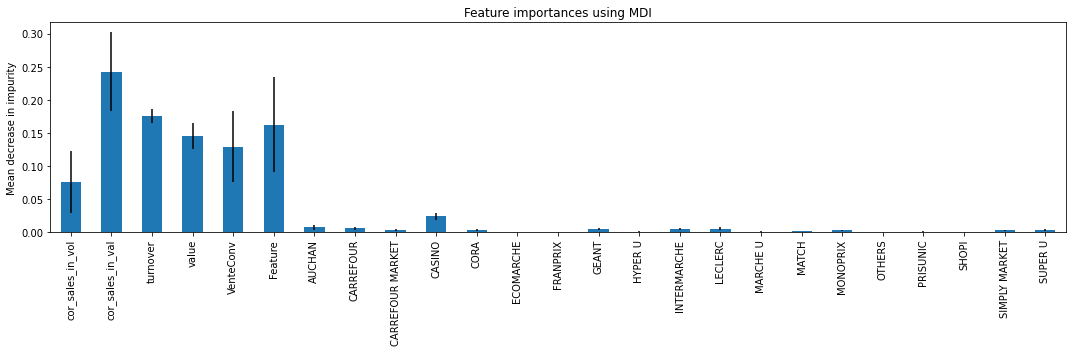

In [ ]:
import pandas as pd

forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots(figsize = (15,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
 xgb = XGBClassifier(n_estimators=500, booster="gbtree", n_jobs=-1, subsample=0.7, random_state=42, tree_method="gpu_hist", gpu_id=0)
 xgb.fit(X_train, y_train)

In [ ]:
ypredxgb = xgb.predict(X_test)
print(classification_report(y_test, y_predxgb))

              precision    recall  f1-score   support

           0       0.68      0.37      0.48      2504
           1       0.96      0.99      0.97     37644

    accuracy                           0.95     40148
   macro avg       0.82      0.68      0.73     40148
weighted avg       0.94      0.95      0.94     40148



In [ ]:
import time
start = time.time()

space_lr = {'max_depth': hp.quniform('max_depth', 3, 10,1),
            'max_features': hp.uniform('max_features', 0.8, 1),
            'learning_rate': hp.uniform('learning_rate',0.01, 1),
            'n_estimators': hp.quniform('n_estimators', 80,150,5),
            'subsample': hp.uniform('subsample',0.8, 1),
            "tree_method":"gpu_hist",
            "gpu_id":0}
acc_score = make_scorer(accuracy_score) 
def xgb_h2o_(params):
    params = {'max_depth': int(params['max_depth']),
              'max_features': params['max_features'],
              'learning_rate': params['learning_rate'],
              'n_estimators': int(params['n_estimators']),
              'subsample': params['subsample']}
    xgb_h2o = XGBClassifier(random_state=42, **params)
    best_score = cross_val_score(xgb_h2o, X_train, y_train, scoring=acc_score, cv=5).mean()
    return 1 - best_score
xgb_best_param = fmin(fn=xgb_h2o_,
                space=space_lr,
                max_evals=24,
                rstate=np.random.RandomState(42),
                algo=tpe.suggest)
print('It takes %s minutes' % ((time.time() - start)/60))

100%|██████████| 24/24 [50:57<00:00, 127.40s/it, best loss: 0.048365700774716025]
It takes 50.95863757133484 minutes


In [ ]:
import copy

best_params = copy.copy(xgb_best_param)
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

In [ ]:
 xgb_best = XGBClassifier(**best_params, booster="gbtree", n_jobs=-1, random_state=42, tree_method="gpu_hist", gpu_id=0)
 xgb_best.fit(X_train, y_train)

XGBClassifier(gpu_id=0, learning_rate=0.36205847620837145, max_depth=10,
              max_features=0.8867347237550754, n_estimators=115, n_jobs=-1,
              random_state=42, subsample=0.9982582858157947,
              tree_method='gpu_hist')

Aprés avoir entrainé le modele, on l'alimente avec les données de test et on a obtenue des métriques ci-dessous.

In [ ]:
y_xgb_best = xgb_best.predict(X_test)
print(classification_report(y_test, y_xgb_best))

              precision    recall  f1-score   support

           0       0.70      0.46      0.56      2504
           1       0.97      0.99      0.98     37644

    accuracy                           0.95     40148
   macro avg       0.83      0.72      0.77     40148
weighted avg       0.95      0.95      0.95     40148



In [ ]:
votemodel = VotingClassifier(
    estimators = [('rf', forest), ('xgb', xgb_best)],
    voting = 'soft'

)
votemodel.fit(X_train, y_train)
votingpred = votemodel.predict(X_test)
print(classification_report(y_test, votingpred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

              precision    recall  f1-score   support

           0       0.60      0.62      0.61      2504
           1       0.97      0.97      0.97     37644

    accuracy                           0.95     40148
   macro avg       0.79      0.80      0.79     40148
weighted avg       0.95      0.95      0.95     40148



In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=25, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor = "loss", patience = 10)
model.fit(X_train, y_train, epochs=150, batch_size=50)

Epoch 1/150
3212/3212 [==============================] - 13s 4ms/step - loss: 0.1313 - accuracy: 0.9543
Epoch 2/150
3212/3212 [==============================] - 18s 6ms/step - loss: 0.1312 - accuracy: 0.9541
Epoch 3/150
3212/3212 [==============================] - 22s 7ms/step - loss: 0.1310 - accuracy: 0.9547
Epoch 4/150
3212/3212 [==============================] - 17s 5ms/step - loss: 0.1309 - accuracy: 0.9544
Epoch 5/150
3212/3212 [==============================] - 12s 4ms/step - loss: 0.1309 - accuracy: 0.9541
Epoch 6/150
3212/3212 [==============================] - 12s 4ms/step - loss: 0.1309 - accuracy: 0.9544
Epoch 7/150
3212/3212 [==============================] - 12s 4ms/step - loss: 0.1308 - accuracy: 0.9543
Epoch 8/150
3212/3212 [==============================] - 12s 4ms/step - loss: 0.1309 - accuracy: 0.9544
Epoch 9/150
3212/3212 [==============================] - 12s 4ms/step - loss: 0.1307 - accuracy: 0.9544
Epoch 10/150
3212/3212 [==============================] - 12s 4m

Aprés avoir entrainé le modele, on l'alimente avec les données de test et on a obtenue des métriques suivantes :

In [ ]:
y_nrl_mdl = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_nrl_mdl))

              precision    recall  f1-score   support

           0       0.67      0.43      0.52      2504
           1       0.96      0.99      0.97     37644

    accuracy                           0.95     40148
   macro avg       0.82      0.71      0.75     40148
weighted avg       0.94      0.95      0.95     40148

